In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import time
import sklearn
from random import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from tabulate import tabulate
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier

evaluate={'Acc':"Accuracy", 'b_Acc':"Balanced Accuracy", 'F1':"F1 Score", 'kap':"Kappa", 'ROC':"Roc"}

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost

In [4]:
def GA(train,test,cols,gen_number=25,outputcsv="GA_output.csv"):
    #defining various steps required for the genetic algorithm
    # GA adapted from https://datascienceplus.com/genetic-algorithm-in-machine-learning-using-python/
    def initilization_of_population(size,n_feat):
        population = []
        for i in range(size):
            chromosome = np.ones(n_feat,dtype=np.bool)
            chromosome[:int(0.3*n_feat)]=False
            np.random.shuffle(chromosome)
            population.append(chromosome)
        return population

    def fitness_score(population):
        scores = []
        for chromosome in population:
            logmodel.fit(X_train.iloc[:,chromosome],y_train)
            predictions = logmodel.predict(X_test.iloc[:,chromosome])
            scores.append(sklearn.metrics.f1_score(y_test,predictions,average= "macro"))
        scores, population = np.array(scores), np.array(population) 
        inds = np.argsort(scores)
        return list(scores[inds][::-1]), list(population[inds,:][::-1])

    def selection(pop_after_fit,n_parents):
        population_nextgen = []
        for i in range(n_parents):
            population_nextgen.append(pop_after_fit[i])
        return population_nextgen

    def crossover(pop_after_sel):
        population_nextgen=pop_after_sel
        for i in range(len(pop_after_sel)):
            child=pop_after_sel[i]
            child[3:7]=pop_after_sel[(i+1)%len(pop_after_sel)][3:7]
            population_nextgen.append(child)
        return population_nextgen

    def mutation(pop_after_cross,mutation_rate):
        population_nextgen = []
        for i in range(0,len(pop_after_cross)):
            chromosome = pop_after_cross[i]
            for j in range(len(chromosome)):
                if random.random() < mutation_rate:
                    chromosome[j]= not chromosome[j]
            population_nextgen.append(chromosome)
        #print(population_nextgen)
        return population_nextgen

    def generations(size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                       X_test, y_train, y_test):

        best_chromo= []
        best_score= []
        population_nextgen=initilization_of_population(size,n_feat)
        for i in range(n_gen):
            second=time.time()
            scores, pop_after_fit = fitness_score(population_nextgen)
            #print(scores[:2])
            zaman=time.time()-second

            ths.write(f"{np.mean(scores)},{np.mean(scores)},{zaman}\n")
            
            pop_after_sel = selection(pop_after_fit,n_parents)
            pop_after_cross = crossover(pop_after_sel)
            population_nextgen = mutation(pop_after_cross,mutation_rate)
            best_chromo.append(pop_after_fit[0])
            best_score.append(scores[0])
        return best_chromo,best_score
    
    df = pd.read_csv(train,usecols=cols)#,header=None )
    df=df.fillna(0)
    #df = df.sample(n = 10000)
    X_train =df[df.columns[0:-1]]
    #X_train=np.array(X_train)
    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y_train=df[df.columns[-1]].cat.codes  
    df = pd.read_csv(test,usecols=cols)#,header=None )
    df=df.fillna(0)
    #df = df.sample(n = 10000)
    X_test =df[df.columns[0:-1]]
    #X_test=np.array(X_test)
    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y_test=df[df.columns[-1]].cat.codes  

    ths = open(f"./{outputcsv}", "w")
    ths.write("MEAN,STD,TIME\n")
    logmodel=DecisionTreeClassifier()
    #print ('%-30s %-30s %-30s' % ("MEAN","STD","TIME"))
    chromo,score=generations(size=200,n_feat=X_train.shape[1],n_parents=120,mutation_rate=0.005,
                         n_gen=gen_number,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)
    #logmodel.fit(X_train.iloc[:,chromo[-1]],y_train)
    #predictions = logmodel.predict(X_test.iloc[:,chromo[-1]])
    #print("F1 Score score after genetic algorithm is= "+str(sklearn.metrics.f1_score(y_test,predictions,average= "macro")))
    ths.close()
    sonuç=[]
    for k,j in enumerate(chromo):
        temp=X_train.iloc[:,j]
        temp=list(temp.columns)
        temp.append("Label")
        sonuç.append(temp)
    
    np.save(outputcsv.replace("csv","npy"), sonuç)
    gf = pd.read_csv(outputcsv)
    gf=gf["MEAN"].values
    gf=np.argmax(gf) 
    return sonuç[gf],gf

In [5]:
def folder(f_name): #this function creates a folder named "attacks" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

In [6]:
def find_the_way(path,file_format,con=""):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))  
    return files_add

In [7]:
ml_list={
"LR":{
"SYN":LogisticRegression(C=32.2474,penalty="l1",solver="liblinear" ),
"HTTP":LogisticRegression(C=0.0123822 ,penalty="l2",solver="newton-cg" ),
"ACK":LogisticRegression(C=41.9311 ,penalty="l1",solver="liblinear" ),    
"UDP":LogisticRegression(C=1.97843,penalty="l1",solver="liblinear" ),    
"ARP":LogisticRegression(C=0.0603198 ,penalty="l1",solver="liblinear" ),
"SP":LogisticRegression(C=2.83382 ,penalty="l1",solver="liblinear" ),    
"BF":LogisticRegression(C=40.6858 ,penalty="l1",solver="liblinear" ),    
"OS":LogisticRegression(C=0.261397,penalty="l1",solver="liblinear" ),
"SCHD":LogisticRegression(C=6.90938,penalty="l1",solver="liblinear" ),    
"MHDis":LogisticRegression(C=1.02992,penalty="l2",solver="newton-cg" )},   

"DT":{
"SYN":DecisionTreeClassifier(criterion="gini",max_depth=26,max_features=31,min_samples_split=2 ),
"HTTP":DecisionTreeClassifier(criterion="gini",max_depth=1,max_features=6,min_samples_split=7 ),                      
"ACK":DecisionTreeClassifier(criterion="gini",max_depth=9,max_features=31,min_samples_split=5),            
"UDP":DecisionTreeClassifier(criterion="entropy",max_depth=2,max_features=8,min_samples_split=8 ),            
"ARP":DecisionTreeClassifier(criterion="entropy",max_depth=20,max_features=31,min_samples_split=4 ),            
"SP":DecisionTreeClassifier(criterion="entropy",max_depth=3,max_features=35,min_samples_split=5 ),            
"BF":DecisionTreeClassifier(criterion="entropy",max_depth=7,max_features=37,min_samples_split=5 ),              
"OS":DecisionTreeClassifier(criterion="gini",max_depth=26,max_features=38,min_samples_split=6 ),            
"SCHD":DecisionTreeClassifier(criterion="gini",max_depth=2,max_features=22,min_samples_split=2 ),             
"MHDis":DecisionTreeClassifier(criterion="gini",max_depth=12,max_features=32,min_samples_split=2 )},
}

In [8]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [9]:
folder("results")
folder("pdfs")
folder("results/fin")
folder("models")
folder("results/test")

## Calculation of evaluations

In [10]:
def score(train_time,test_time,predict,y_test,class_based_results,repeat,cv,dname,ml,sw):
    train_time=train_time[0]
    test_time=test_time[0]
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")     
    accuracy=sklearn.metrics.accuracy_score(y_test, predict)
    accuracy_b=sklearn.metrics.balanced_accuracy_score( y_test,predict)
    kappa=sklearn.metrics.cohen_kappa_score(y_test, predict,labels=None, weights=None, sample_weight=None)
    try:
        roc=sklearn.metrics.roc_auc_score(y_test, predict)
    except:roc=0
    report = sklearn.metrics.classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    line=[dname,sw,repeat,cv,ml,accuracy,accuracy_b,pr,rc,f_1,kappa,roc,train_time,test_time]

    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    return class_based_results,line

In [11]:
def ML_CV(loop1,loop2,output_csv1,cols,dname,sw):
    fold=5
    repetition=2
    for ii in ml_list:
        output_csv=output_csv1.replace("ML",ii)
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        max_f1=0
        for i in range(repetition):

            rnd = random()
            
            kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            ##df = df.reset_index(drop=True)
            df=df.fillna(0)

            #del df["MAC"] # if dataset has MAC colomn please uncomment this line
            X =df[df.columns[0:-1]]
            X=np.array(X)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y=df[df.columns[-1]].cat.codes  
            X.shape
            for train_index, test_index in kfold.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]  

                #dname=loop1  [6:-13]  
                results_y=[]
                cv+=1
                results_y.append(y_test)

                precision=[]
                recall=[]
                f1=[]
                accuracy=[]
                train_time=[]
                test_time=[]
                total_time=[]
                kappa=[]
                accuracy_b=[]

                    #machine learning algorithm is applied in this section
                clf = ml_list[ii][dname]#choose algorithm from ml_list dictionary
                second=time.time()
                clf.fit(X_train, y_train)
                train_time.append(float((time.time()-second)) )
                second=time.time()
                predict =clf.predict(X_test)
                test_time.append(float((time.time()-second)) )

                altime=0
                class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
                lines.append(line)
                df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
                if cm.empty:
                    cm =df_cm
                else:
                    cm = cm.add(df_cm, fill_value=0)

                if line[9]>max_f1:
                    max_f1=line[9]
                    pickle.dump(clf, open(f'./models/{ii}_{dname}_{sw}_model.pkl', 'wb'))
        
        class_based_results=class_based_results/(repetition*fold)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()
        
        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","class_based_results.csv"))
        if True:
            cm=cm//(repetition*fold)
            graph_name=output_csv[:-4]+"_confusion matrix.pdf"   
            plt.figure(figsize = (5,3.5))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             

In [12]:
def ML(loop1,loop2,output_csv1,cols,dname,sw):
    fold=1
    repetition=10
    for ii in ml_list:
        output_csv=output_csv1.replace("ML",ii)
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        max_f1=0
        for i in range(repetition):

            #rnd = random()
            
            #kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_train =df[df.columns[0:-1]]
            X_train=np.array(X_train)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_train=df[df.columns[-1]].cat.codes  

            df = pd.read_csv(loop2,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_test =df[df.columns[0:-1]]
            X_test=np.array(X_test)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_test=df[df.columns[-1]].cat.codes  

            #dname=loop1  [6:-13]  
            results_y=[]
            cv+=1
            results_y.append(y_test)

            precision=[]
            recall=[]
            f1=[]
            accuracy=[]
            train_time=[]
            test_time=[]
            total_time=[]
            kappa=[]
            accuracy_b=[]

                #machine learning algorithm is applied in this section
            clf = ml_list[ii][dname]#choose algorithm from ml_list dictionary
            second=time.time()
            clf.fit(X_train, y_train)
            train_time.append(float((time.time()-second)) )
            second=time.time()
            predict =clf.predict(X_test)
            test_time.append(float((time.time()-second)) )

            altime=0
            class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
            lines.append(line)
            df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
            if cm.empty:
                cm =df_cm
            else:
                cm = cm.add(df_cm, fill_value=0)

            if line[9]>max_f1:
                max_f1=line[9]
                pickle.dump(clf, open(f'./models/{ii}_{dname}_{sw}_model.pkl', 'wb'))
                
        class_based_results=class_based_results/(repetition*fold)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()
        
        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","class_based_results.csv"))
        if True:
            cm=cm//(repetition*fold)
            graph_name=output_csv[:-4]+"_confusion matrix.pdf"   
            plt.figure(figsize = (5,3.5))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             

# GA output

In [13]:
import json
with open('GA_output_ET.json', 'r') as fp:
    feature_list = json.load(fp)

# CV

In [14]:
file_list={
'../csvs\\dos-synflooding-1-dec.pcap_Flow.csv':"SYN",
'../csvs\\mirai-httpflooding-4-dec.pcap_Flow.csv':"HTTP",
'../csvs\\mirai-ackflooding-4-dec.pcap_Flow.csv':"ACK",
'../csvs\\mirai-udpflooding-4-dec.pcap_Flow.csv':"UDP",
'../csvs\\mitm-arpspoofing-6-dec.pcap_Flow.csv':"ARP",
'../csvs\\scan-hostport-3-dec.pcap_Flow.csv':"SP",
'../csvs\\mirai-hostbruteforce-5-dec.pcap_Flow.csv':"BF",
'../csvs\\scan-portos-3-dec.pcap_Flow.csv':"OS",  
'../csvs\\scan-hostport-3-dec.pcap_Flow.csv':"SCHD",
'../csvs\\mirai-hostbruteforce-3-dec.pcap_Flow.csv':"MHDis"}

../csvs\dos-synflooding-1-dec.pcap_Flow.csv
['Src Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow IAT Mean', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Max', 'Fwd Header Len', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'SYN Flag Cnt', 'Subflow Fwd Pkts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Active Std', 'Active Max', 'Active Min', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  LR    1        0.944   1      0.944  0.971  0.941  0.944   20.47      0.001
 1  SYN           0    2     0  LR    1        1       0.944  1      0.9

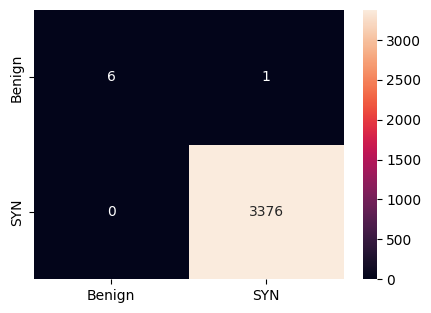





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  DT    1        1           1  1      1      1      1        0.051     0.001
 1  SYN           0    2     0  DT    0.999    0.875       1  0.875  0.928  0.857  0.875    0.038     0
 2  SYN           0    3     0  DT    1        1           1  1      1      1      1        0.057     0.001
 3  SYN           0    4     0  DT    1        1           1  1      1      1      1        0.061     0.001
 4  SYN           0    5     0  DT    1        1           1  1      1      1      1        0.062     0
 5  SYN           0    1     1  DT    1        1           1  1      1      1      1        0.068     0.001
 6  SYN           0    2     1  DT    1        1           1  1      1      1      1        0.086     0.001
 7  SYN           0    3     1  

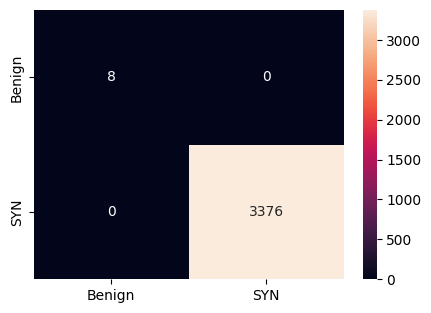





../csvs\mirai-httpflooding-4-dec.pcap_Flow.csv
['Dst Port', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Max', 'Fwd IAT Max', 'SYN Flag Cnt', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  LR    0.894    0.889   0.89   0.889  0.89   0.779  0.889    0.296     0.001
 1  HTTP          0    2     0  LR    0.921    0.906   0.938  0.906  0.916  0.833  0.906    0.244     0
 2  HTTP          0    3     0  LR    0.899    0.888   0.907  0.888  0.894  0.789  0.888    0.222     0
 3  HTTP          0    4     0  LR    0.943    0.921   0.951  0.921  0.934  0.868  0.921    0.439     0.001
 4  HTTP          0    5     0  LR    0.916    0.902   0.923  0.902  0.91   0.82   0.902    0.251     0.001
 5  HTTP          0    1     1  LR    0.94     0.924   0.955  0.924  0.935  0.871  0.924    0.209   

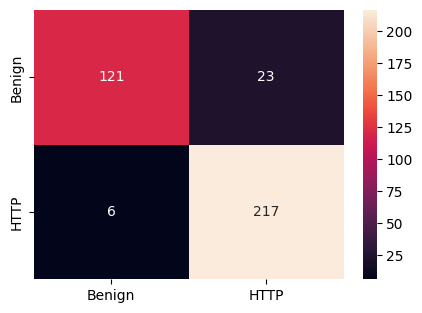





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  DT    0.918    0.893   0.942  0.893  0.909  0.82   0.893    0.002     0
 1  HTTP          0    2     0  DT    0.938    0.922   0.953  0.922  0.933  0.866  0.922    0.004     0
 2  HTTP          0    3     0  DT    0.943    0.92    0.959  0.92   0.935  0.871  0.92     0.009     0
 3  HTTP          0    4     0  DT    0.891    0.876   0.919  0.876  0.885  0.773  0.876    0.002     0.001
 4  HTTP          0    5     0  DT    0.929    0.908   0.948  0.908  0.922  0.846  0.908    0.002     0.001
 5  HTTP          0    1     1  DT    0.938    0.919   0.954  0.919  0.932  0.864  0.919    0.008     0.001
 6  HTTP          0    2     1  DT    0.905    0.873   0.934  0.873  0.892  0.786  0.873    0.006     0.001
 7  HTTP          0    3     1  DT  

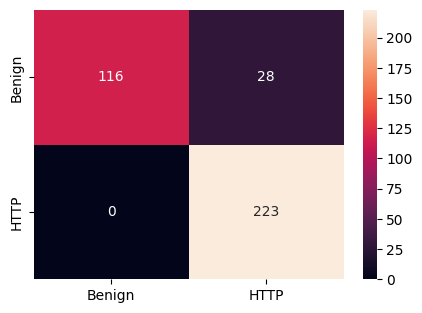





../csvs\mirai-ackflooding-4-dec.pcap_Flow.csv
['Dst Port', 'Flow Duration', 'Tot Fwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Max', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Pkt Len Mean', 'Pkt Len Std', 'ACK Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Bwd Seg Size Avg', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Idle Mean', 'Idle Std', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  LR    0.976    0.98    0.971  0.98   0.975  0.949  0.98     1.74      0.001
 1  ACK           0    2     0  LR    0.98     0.981   0.976  0.981  0.978

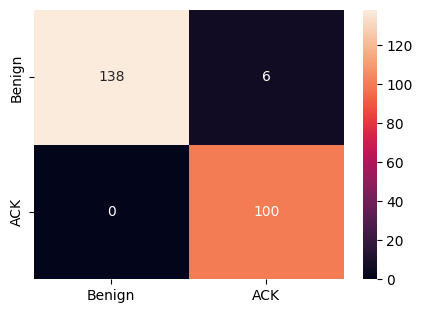





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  DT    1        1       1      1      1      1      1        0.009     0.001
 1  ACK           0    2     0  DT    1        1       1      1      1      1      1        0.012     0.001
 2  ACK           0    3     0  DT    1        1       1      1      1      1      1        0.007     0
 3  ACK           0    4     0  DT    0.984    0.983   0.983  0.983  0.983  0.966  0.983    0.015     0
 4  ACK           0    5     0  DT    1        1       1      1      1      1      1        0.015     0.001
 5  ACK           0    1     1  DT    0.996    0.997   0.995  0.997  0.996  0.991  0.997    0.005     0
 6  ACK           0    2     1  DT    1        1       1      1      1      1      1        0.005     0
 7  ACK           0    3     1  DT    1 

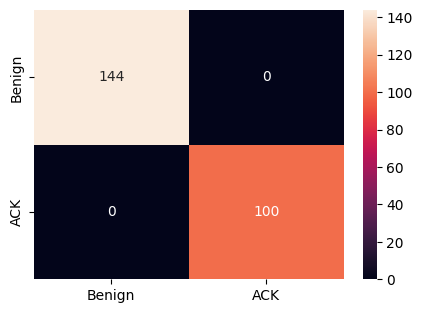





../csvs\mirai-udpflooding-4-dec.pcap_Flow.csv
['Src Port', 'Flow Duration', 'TotLen Fwd Pkts', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow Byts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Fwd Act Data Pkts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  LR    1        1       1      1      1      1      1        0.037     0
 1  UDP           0    2     0  LR    1        1       1      1      1      1      1        0.009     0
 2  UDP           0    3     0  LR    1        1       1      1      1      1      1

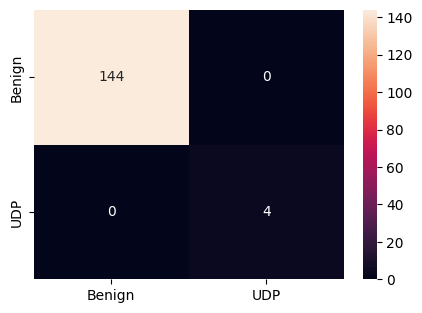





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  DT    1        1       1      1      1      1      1        0.001     0
 1  UDP           0    2     0  DT    1        1       1      1      1      1      1        0.003     0
 2  UDP           0    3     0  DT    1        1       1      1      1      1      1        0.004     0
 3  UDP           0    4     0  DT    1        1       1      1      1      1      1        0.005     0
 4  UDP           0    5     0  DT    1        1       1      1      1      1      1        0.001     0.001
 5  UDP           0    1     1  DT    1        1       1      1      1      1      1        0.002     0
 6  UDP           0    2     1  DT    1        1       1      1      1      1      1        0.002     0.001
 7  UDP           0    3     1  DT    1     

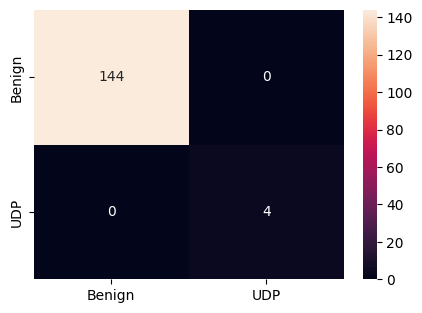





../csvs\mitm-arpspoofing-6-dec.pcap_Flow.csv
['Src Port', 'Dst Port', 'Protocol', 'Fwd Pkt Len Max', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow Pkts/s', 'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd Pkts/s', 'Pkt Len Var', 'SYN Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Active Std', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  LR    0.952    0.95    0.952  0.95   0.951  0.902  0.95     0.091     0
 1  ARP           0    2     0  LR    0.942    0.939   0.944  0.939  0.941  0.882  0.939    0.109     0
 2  ARP 

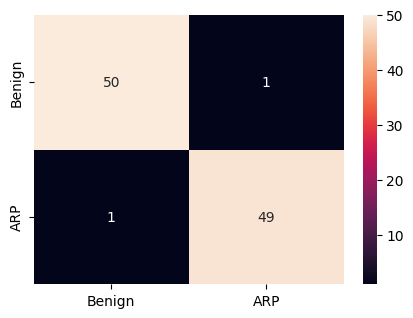





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  DT    0.981    0.981   0.981  0.981  0.981  0.962  0.981    0.004     0
 1  ARP           0    2     0  DT    0.952    0.952   0.949  0.952  0.951  0.901  0.952    0.011     0
 2  ARP           0    3     0  DT    0.981    0.982   0.98   0.982  0.981  0.961  0.982    0.004     0
 3  ARP           0    4     0  DT    0.99     0.99    0.991  0.99   0.99   0.981  0.99     0.004     0
 4  ARP           0    5     0  DT    0.971    0.971   0.971  0.971  0.971  0.942  0.971    0.004     0
 5  ARP           0    1     1  DT    0.981    0.982   0.98   0.982  0.981  0.961  0.982    0.011     0.001
 6  ARP           0    2     1  DT    0.962    0.962   0.962  0.962  0.962  0.923  0.962    0.004     0
 7  ARP           0    3     1  DT    0.99     0

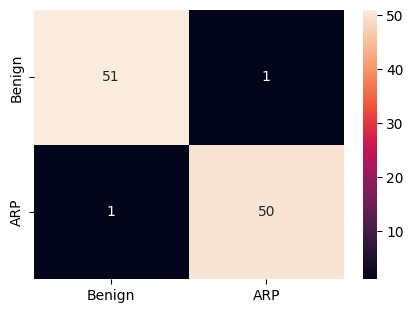





../csvs\scan-hostport-3-dec.pcap_Flow.csv
['Dst Port', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow Pkts/s', 'Flow IAT Mean', 'Fwd IAT Tot', 'Fwd IAT Std', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd PSH Flags', 'Fwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Std', 'Idle Mean', 'Idle Std', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  LR    1        1       1      1      1      1      1        0.016     0.001
 1  SCHD          0    2     0  LR    1        1 

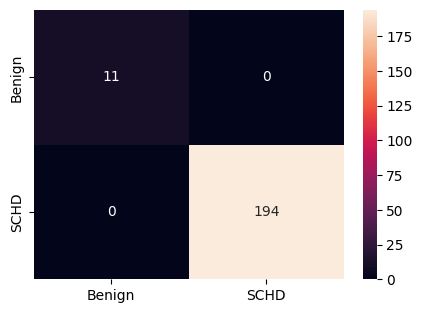





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  DT     1       1       1      1      1      1      1        0.013     0
 1  SCHD          0    2     0  DT     1       1       1      1      1      1      1        0.002     0.001
 2  SCHD          0    3     0  DT     1       1       1      1      1      1      1        0.002     0.001
 3  SCHD          0    4     0  DT     1       1       1      1      1      1      1        0.002     0
 4  SCHD          0    5     0  DT     1       1       1      1      1      1      1        0.01      0
 5  SCHD          0    1     1  DT     1       1       1      1      1      1      1        0.002     0
 6  SCHD          0    2     1  DT     0.99    0.995   0.889  0.995  0.935  0.87   0.995    0.002     0
 7  SCHD          0    3     1  DT     1    

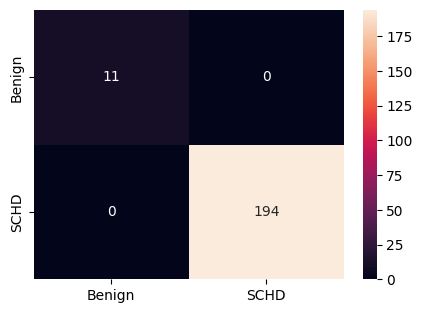





../csvs\mirai-hostbruteforce-5-dec.pcap_Flow.csv
['Dst Port', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Active Mean', 'Active Std', 'Active Max', 'Idle Mean', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  LR    0.909    0.801   0.838  0.801  0.818  0.636  0.801    0.829     0.001
 1  BF 

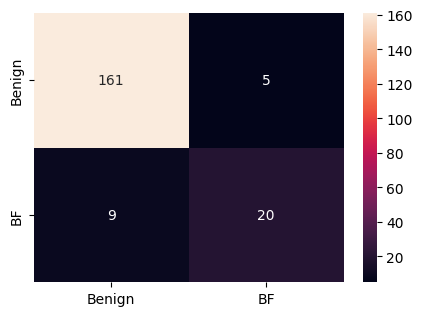





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  DT    0.975    0.95    0.961  0.95   0.955  0.91   0.95     0.037     0.001
 1  BF            0    2     0  DT    0.975    0.919   0.985  0.919  0.949  0.898  0.919    0.034     0
 2  BF            0    3     0  DT    0.995    0.98    0.997  0.98   0.988  0.977  0.98     0.018     0.001
 3  BF            0    4     0  DT    0.985    0.965   0.977  0.965  0.971  0.942  0.965    0.026     0
 4  BF            0    5     0  DT    0.98     0.958   0.958  0.958  0.958  0.917  0.958    0.014     0.004
 5  BF            0    1     1  DT    0.985    0.974   0.959  0.974  0.966  0.932  0.974    0.019     0
 6  BF            0    2     1  DT    0.99     0.964   0.994  0.964  0.979  0.957  0.964    0.024     0.001
 7  BF            0    3     1  DT  

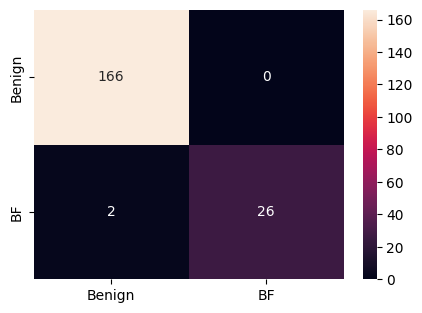





../csvs\scan-portos-3-dec.pcap_Flow.csv
['Dst Port', 'Protocol', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Bwd IAT Tot', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd Header Len', 'Pkt Len Min', 'Pkt Len Std', 'Pkt Len Var', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Fwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            0    1     0  LR    0.988    0.952   0.993  0.952  0.971  0.942  0.952    0.356

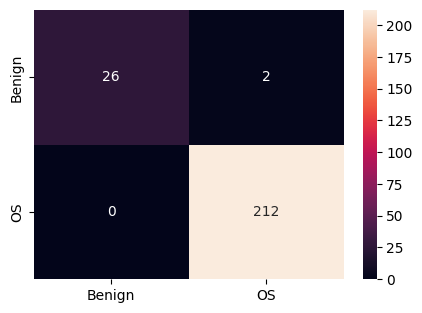





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            0    1     0  DT    0.988    0.98    0.967  0.98   0.973  0.947  0.98     0.026     0.001
 1  OS            0    2     0  DT    0.983    0.952   0.952  0.952  0.952  0.904  0.952    0.018     0
 2  OS            0    3     0  DT    0.975    0.96    0.938  0.96   0.949  0.897  0.96     0.011     0
 3  OS            0    4     0  DT    0.992    0.981   0.981  0.981  0.981  0.963  0.981    0.012     0.002
 4  OS            0    5     0  DT    0.996    0.998   0.979  0.998  0.988  0.976  0.998    0.007     0
 5  OS            0    1     1  DT    0.983    0.969   0.932  0.969  0.95   0.9    0.969    0.011     0
 6  OS            0    2     1  DT    0.992    0.98    0.98   0.98   0.98   0.961  0.98     0.005     0.001
 7  OS            0    3     1  DT    0.

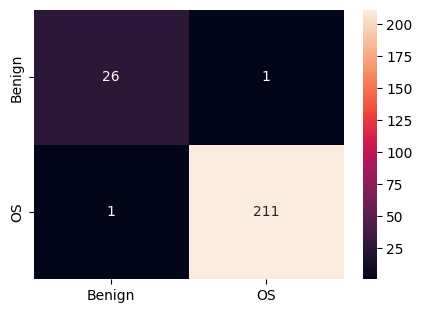





../csvs\mirai-hostbruteforce-3-dec.pcap_Flow.csv
['Src Port', 'Dst Port', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd Header Len', 'Fwd Pkts/s', 'Pkt Len Mean', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Active Mean', 'Active Std', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  LR    0.855    0.667   0.743  0.667  0.693  0.39   0.667    0.792     0
 1  MHDis         0    2     0  LR    0.872    0.713   0.749  0.713  0.729  0.458  0.713    0.84    

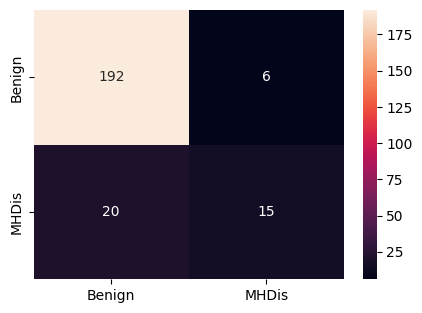





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  DT    0.962    0.95    0.895  0.95   0.92   0.839  0.95     0.022     0.001
 1  MHDis         0    2     0  DT    0.983    0.955   0.977  0.955  0.966  0.931  0.955    0.02      0
 2  MHDis         0    3     0  DT    0.979    0.987   0.938  0.987  0.96   0.921  0.987    0.024     0
 3  MHDis         0    4     0  DT    0.996    0.987   0.997  0.987  0.992  0.984  0.987    0.023     0
 4  MHDis         0    5     0  DT    0.996    0.997   0.988  0.997  0.993  0.986  0.997    0.03      0.001
 5  MHDis         0    1     1  DT    0.991    0.981   0.981  0.981  0.981  0.962  0.981    0.015     0.001
 6  MHDis         0    2     1  DT    0.979    0.969   0.961  0.969  0.965  0.931  0.969    0.021     0.001
 7  MHDis         0    3     1  DT  

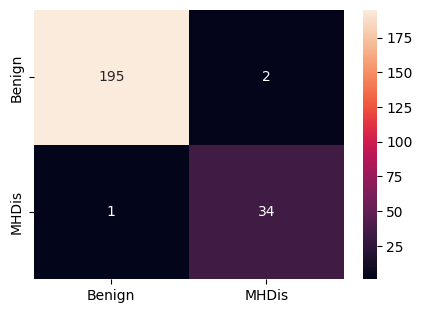

In [15]:
folder("results/cv/")

for file in file_list:
    print(file)
    feature=feature_list[file_list[file]]
    train=file
    test=file
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/cv/{file_list[file]}_VAL_chosed_output_ML_.csv"
    target_names=["Benign",file_list[file]]
    ML_CV(train,test,output_csv,feature,file_list[file],0)   

# SS

In [16]:
file_list_session={
"SYN":[ '../csvs\\dos-synflooding-1-dec.pcap_Flow.csv', '../csvs\\dos-synflooding-2-dec.pcap_Flow.csv',],
"HTTP":['../csvs\\mirai-httpflooding-4-dec.pcap_Flow.csv', '../csvs\\mirai-httpflooding-1-dec.pcap_Flow.csv'],
"ACK":['../csvs\\mirai-ackflooding-4-dec.pcap_Flow.csv','../csvs\\mirai-ackflooding-1-dec.pcap_Flow.csv'],
"UDP":[ '../csvs\\mirai-udpflooding-4-dec.pcap_Flow.csv','../csvs\\mirai-udpflooding-1-dec.pcap_Flow.csv'],
"ARP":[ '../csvs\\mitm-arpspoofing-6-dec.pcap_Flow.csv', '../csvs\\mitm-arpspoofing-4-dec.pcap_Flow.csv'],
"SP":['../csvs\\scan-hostport-3-dec.pcap_Flow.csv','../csvs\\scan-hostport-4-dec.pcap_Flow.csv'],
"BF":[ '../csvs\\mirai-hostbruteforce-5-dec.pcap_Flow.csv','../csvs\\mirai-hostbruteforce-3-dec.pcap_Flow.csv'],
"OS":['../csvs\\scan-portos-3-dec.pcap_Flow.csv','../csvs\\scan-portos-6-dec.pcap_Flow.csv'],
"SCHD":['../csvs\\scan-hostport-3-dec.pcap_Flow.csv','../csvs\\scan-hostport-4-dec.pcap_Flow.csv'],
"MHDis":['../csvs\\mirai-hostbruteforce-3-dec.pcap_Flow.csv','../csvs\\mirai-hostbruteforce-2-dec.pcap_Flow.csv']}

SYN
['Src Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow IAT Mean', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Max', 'Fwd Header Len', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'SYN Flag Cnt', 'Subflow Fwd Pkts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Active Std', 'Active Max', 'Active Min', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  LR    0.999    0.901   0.986  0.901  0.939  0.879  0.901   48.716     0.002
 1  SYN           0    1     1  LR    0.998    0.874   0.985  0.874  0.922  0.844  0.874   33.838     0.002
 2  

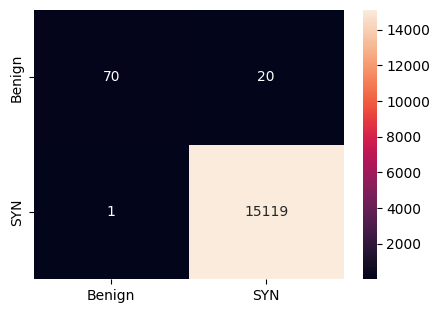





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  DT    1        1       0.989  1      0.995  0.989  1        0.066     0.006
 1  SYN           0    1     1  DT    1        0.972   0.988  0.972  0.98   0.961  0.972    0.074     0.004
 2  SYN           0    1     2  DT    0.999    0.945   0.988  0.945  0.965  0.931  0.945    0.099     0.002
 3  SYN           0    1     3  DT    1        0.984   1      0.984  0.992  0.983  0.984    0.075     0.004
 4  SYN           0    1     4  DT    1        0.989   1      0.989  0.994  0.989  0.989    0.076     0.003
 5  SYN           0    1     5  DT    1        0.989   0.989  0.989  0.989  0.978  0.989    0.063     0.002
 6  SYN           0    1     6  DT    1        0.972   0.988  0.972  0.98   0.961  0.972    0.074     0.003
 7  SYN           0    1

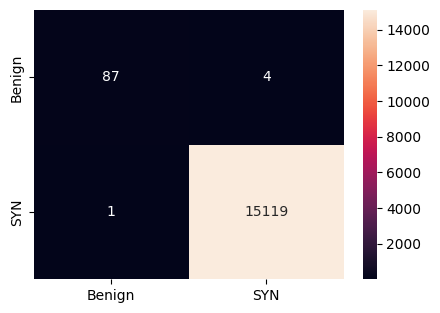





HTTP
['Dst Port', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Max', 'Fwd IAT Max', 'SYN Flag Cnt', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  LR    0.898    0.882   0.924  0.882  0.892  0.786  0.882    0.484     0.001
 1  HTTP          0    1     1  LR    0.898    0.882   0.924  0.882  0.892  0.786  0.882    0.433     0
 2  HTTP          0    1     2  LR    0.898    0.882   0.924  0.882  0.892  0.786  0.882    0.461     0.001
 3  HTTP          0    1     3  LR    0.898    0.882   0.924  0.882  0.892  0.786  0.882    0.429     0.001
 4  HTTP          0    1     4  LR    0.898    0.882   0.924  0.882  0.892  0.786  0.882    0.482     0.001
 5  HTTP          0    1     5  LR    0.898    0.882   0.924  0.882  0.892  0.786  0.882    0.45      0
 6  HTTP          0    1     6  LR

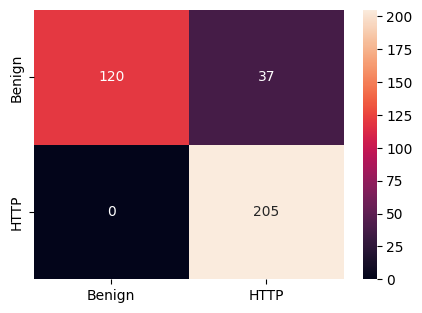





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  DT    0.881    0.863   0.913  0.863  0.873   0.75  0.863    0.003     0
 1  HTTP          0    1     1  DT    0.881    0.863   0.913  0.863  0.873   0.75  0.863    0.004     0
 2  HTTP          0    1     2  DT    0.881    0.863   0.913  0.863  0.873   0.75  0.863    0.008     0
 3  HTTP          0    1     3  DT    0.881    0.863   0.913  0.863  0.873   0.75  0.863    0.002     0.001
 4  HTTP          0    1     4  DT    0.881    0.863   0.913  0.863  0.873   0.75  0.863    0.003     0
 5  HTTP          0    1     5  DT    0.881    0.863   0.913  0.863  0.873   0.75  0.863    0.002     0
 6  HTTP          0    1     6  DT    0.881    0.863   0.913  0.863  0.873   0.75  0.863    0.002     0.001
 7  HTTP          0    1     7  DT    0.881 

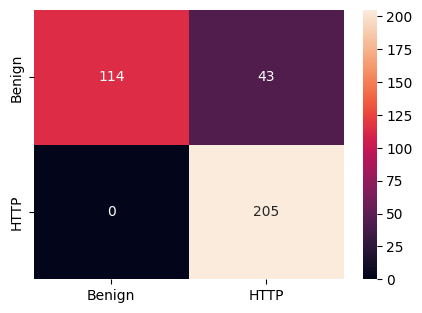





ACK
['Dst Port', 'Flow Duration', 'Tot Fwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Max', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Pkt Len Mean', 'Pkt Len Std', 'ACK Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Bwd Seg Size Avg', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Idle Mean', 'Idle Std', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  LR    0.441    0.699   0.518  0.699  0.336  0.03   0.699    0.836     0.001
 1  ACK           0    1     1  LR    0.335    0.648   0.515  0.648  0.273  0.019  0.648    0.914     0.001
 2  ACK 

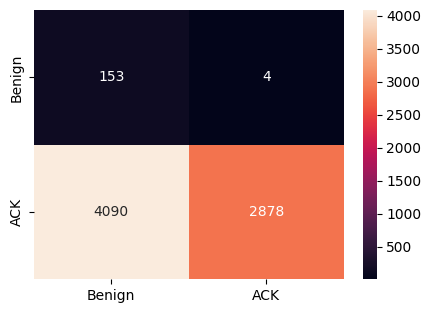





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  DT    0.022    0.5     0.011  0.5    0.022   0     0.5      0.008     0.001
 1  ACK           0    1     1  DT    0.636    0.814   0.529  0.814  0.44    0.07  0.814    0.009     0.002
 2  ACK           0    1     2  DT    0.022    0.5     0.011  0.5    0.022   0     0.5      0.014     0.002
 3  ACK           0    1     3  DT    0.022    0.5     0.011  0.5    0.022   0     0.5      0.014     0.003
 4  ACK           0    1     4  DT    0.636    0.814   0.529  0.814  0.44    0.07  0.814    0.01      0.002
 5  ACK           0    1     5  DT    0.022    0.5     0.011  0.5    0.022   0     0.5      0.014     0.002
 6  ACK           0    1     6  DT    0.022    0.5     0.011  0.5    0.022   0     0.5      0.051     0.002
 7  ACK           0    1

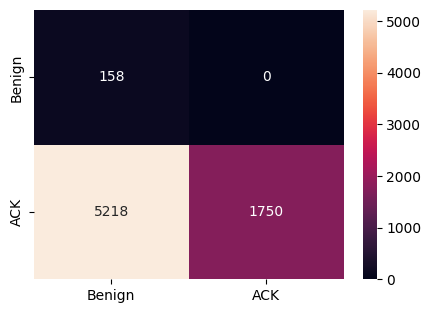





UDP
['Src Port', 'Flow Duration', 'TotLen Fwd Pkts', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow Byts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Fwd Act Data Pkts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  LR    0.457    0.543   0.714  0.543  0.38   0.072  0.543    0.034     0
 1  UDP           0    1     1  LR    0.457    0.543   0.714  0.543  0.38   0.072  0.543    0.018     0
 2  UDP           0    1     2  LR    0.457    0.543   0.714  0.543  0.38   0.072  0.543    0.013     0
 3  UDP           0   

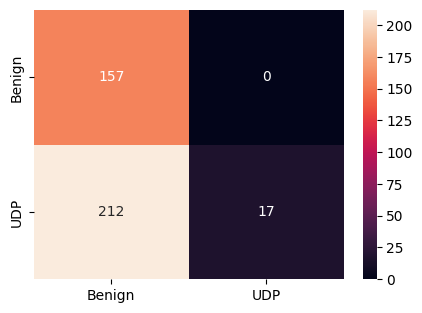





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  DT    0.457    0.543   0.714  0.543  0.38   0.072  0.543    0.005     0.001
 1  UDP           0    1     1  DT    0.457    0.543   0.714  0.543  0.38   0.072  0.543    0.003     0.001
 2  UDP           0    1     2  DT    0.457    0.543   0.714  0.543  0.38   0.072  0.543    0.004     0
 3  UDP           0    1     3  DT    1        1       1      1      1      1      1        0.002     0
 4  UDP           0    1     4  DT    1        1       1      1      1      1      1        0.002     0.001
 5  UDP           0    1     5  DT    0.457    0.543   0.714  0.543  0.38   0.072  0.543    0.002     0
 6  UDP           0    1     6  DT    0.457    0.543   0.714  0.543  0.38   0.072  0.543    0.002     0
 7  UDP           0    1     7  DT    0.

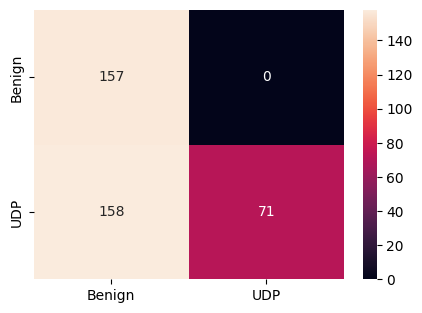





ARP
['Src Port', 'Dst Port', 'Protocol', 'Fwd Pkt Len Max', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow Pkts/s', 'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd Pkts/s', 'Pkt Len Var', 'SYN Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Active Std', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  LR    0.963    0.951   0.966  0.951  0.958  0.916  0.951    0.067     0
 1  ARP           0    1     1  LR    0.96     0.949   0.961  0.949  0.955  0.91   0.949    0.624     0.001
 2  ARP           0    1     2  LR    0.955  

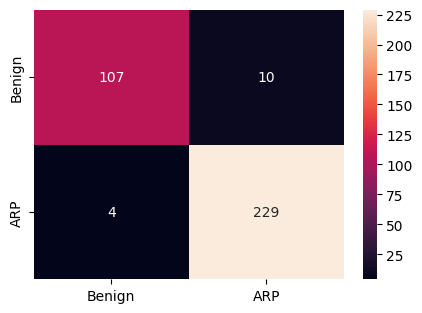





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  DT    0.989    0.989   0.985  0.989  0.987  0.975  0.989    0.008     0.003
 1  ARP           0    1     1  DT    0.989    0.989   0.985  0.989  0.987  0.975  0.989    0.005     0.001
 2  ARP           0    1     2  DT    0.989    0.989   0.985  0.989  0.987  0.975  0.989    0.013     0
 3  ARP           0    1     3  DT    0.989    0.989   0.985  0.989  0.987  0.975  0.989    0.009     0.001
 4  ARP           0    1     4  DT    0.989    0.989   0.985  0.989  0.987  0.975  0.989    0.005     0
 5  ARP           0    1     5  DT    0.989    0.989   0.985  0.989  0.987  0.975  0.989    0.005     0
 6  ARP           0    1     6  DT    0.989    0.989   0.985  0.989  0.987  0.975  0.989    0.009     0
 7  ARP           0    1     7  DT    0.

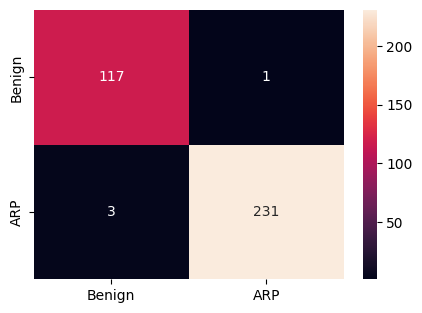





SP
['Protocol', 'Tot Fwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Flow Byts/s', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Header Len', 'Fwd Pkts/s', 'Pkt Len Min', 'Pkt Len Mean', 'Pkt Len Std', 'SYN Flag Cnt', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Active Std', 'Active Max', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  LR    1        1       1      1      1      1      1        0.006     0
 1  SP            0    1     1  LR    0.999    0.995   0.999  0.995  0.997  0.995  

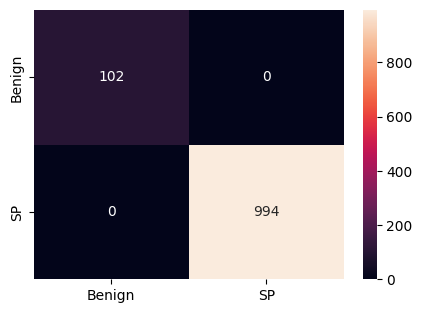





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.008     0.001
 1  SP            0    1     1  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.002     0
 2  SP            0    1     2  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.005     0
 3  SP            0    1     3  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.002     0.001
 4  SP            0    1     4  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.001     0.001
 5  SP            0    1     5  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.001     0.001
 6  SP            0    1     6  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.002     0
 7  SP            0    1     7  DT  

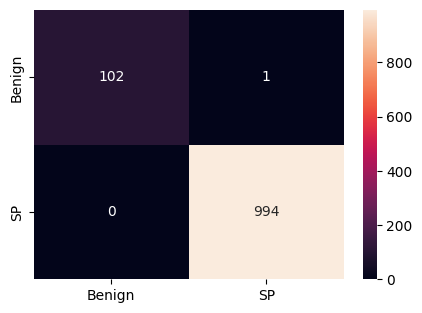





BF
['Dst Port', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Active Mean', 'Active Std', 'Active Max', 'Idle Mean', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  LR    0.884    0.704   0.797  0.704  0.737  0.478  0.704    0.729     0.001
 1  BF            0    1     1  LR    0.884    0.704 

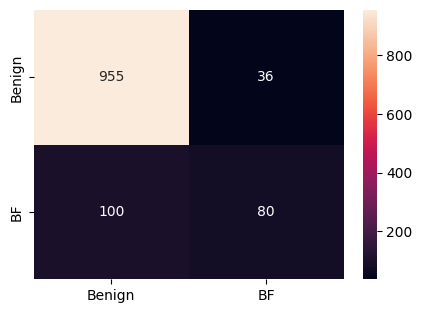





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  DT    0.973    0.918   0.976  0.918  0.944  0.888  0.918    0.045     0.001
 1  BF            0    1     1  DT    0.973    0.922   0.971  0.922  0.945  0.889  0.922    0.042     0.001
 2  BF            0    1     2  DT    0.944    0.826   0.954  0.826  0.875  0.75   0.826    0.035     0.004
 3  BF            0    1     3  DT    0.965    0.893   0.971  0.893  0.927  0.854  0.893    0.037     0
 4  BF            0    1     4  DT    0.973    0.918   0.976  0.918  0.944  0.888  0.918    0.033     0
 5  BF            0    1     5  DT    0.971    0.921   0.965  0.921  0.942  0.883  0.921    0.022     0.001
 6  BF            0    1     6  DT    0.969    0.916   0.964  0.916  0.938  0.876  0.916    0.023     0.001
 7  BF            0    1     7  

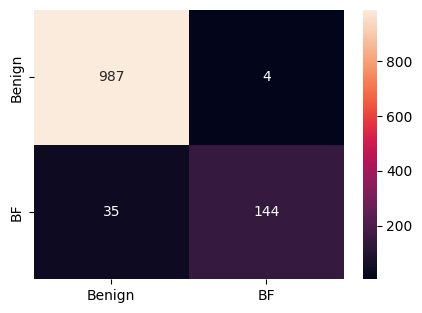





OS
['Dst Port', 'Protocol', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Bwd IAT Tot', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd Header Len', 'Pkt Len Min', 'Pkt Len Std', 'Pkt Len Var', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Fwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            0    1     0  LR    0.997    0.988   0.968  0.988  0.978  0.956  0.988    0.105     0
 1  OS            0    1     1

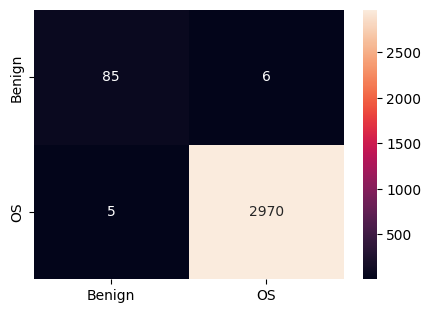





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            0    1     0  DT    0.994    0.955   0.941  0.955  0.948  0.895  0.955    0.017     0.001
 1  OS            0    1     1  DT    0.994    0.966   0.942  0.966  0.954  0.907  0.966    0.014     0.001
 2  OS            0    1     2  DT    0.996    0.977   0.953  0.977  0.965  0.929  0.977    0.01      0.001
 3  OS            0    1     3  DT    0.994    0.965   0.938  0.965  0.951  0.902  0.965    0.011     0.001
 4  OS            0    1     4  DT    0.994    0.965   0.938  0.965  0.951  0.902  0.965    0.012     0
 5  OS            0    1     5  DT    0.995    0.955   0.955  0.955  0.955  0.91   0.955    0.008     0.001
 6  OS            0    1     6  DT    0.994    0.966   0.942  0.966  0.954  0.907  0.966    0.011     0.001
 7  OS            0    1    

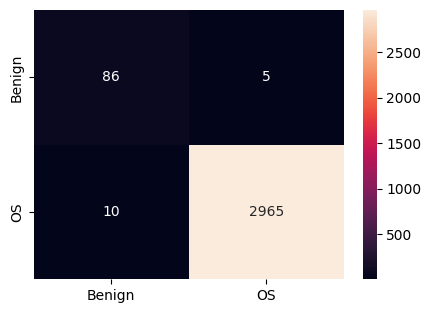





SCHD
['Dst Port', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow Pkts/s', 'Flow IAT Mean', 'Fwd IAT Tot', 'Fwd IAT Std', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd PSH Flags', 'Fwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Std', 'Idle Mean', 'Idle Std', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  LR    0.991    0.995   0.956  0.995  0.974  0.949  0.995    0.008     0.001
 1  SCHD          0    1     1  LR    0.993    0.996   0.964  0.996  0.979  0.959  0.9

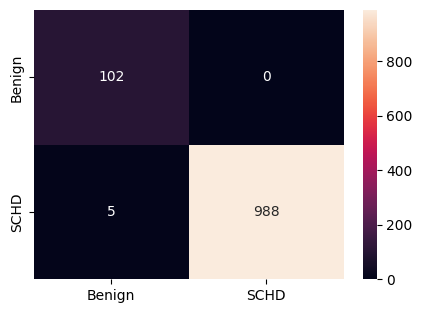





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.003     0
 1  SCHD          0    1     1  DT    0.963    0.936   0.87   0.936  0.899  0.799  0.936    0.003     0
 2  SCHD          0    1     2  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.002     0
 3  SCHD          0    1     3  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.004     0
 4  SCHD          0    1     4  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.003     0.001
 5  SCHD          0    1     5  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.006     0.001
 6  SCHD          0    1     6  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.003     0
 7  SCHD          0    1     7  DT    0.999 

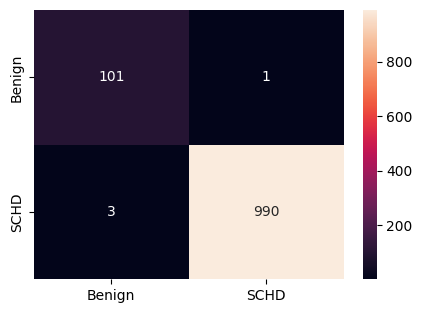





MHDis
['Src Port', 'Dst Port', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd Header Len', 'Fwd Pkts/s', 'Pkt Len Mean', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Active Mean', 'Active Std', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  MHDis         0    1     0  LR    0.771    0.486   0.437  0.486  0.447  -0.039  0.486    0.757     0.001
 1  MHDis         0    1     1  LR    0.771    0.486   0.437  0.486  0.447  -0.039  0.486    0.802     0.001
 2  MHDis         0    1   

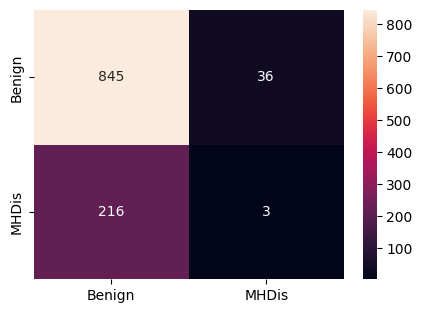





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  DT    0.745    0.534   0.549  0.534  0.535  0.079  0.534    0.019     0
 1  MHDis         0    1     1  DT    0.746    0.536   0.551  0.536  0.538  0.084  0.536    0.017     0
 2  MHDis         0    1     2  DT    0.742    0.53    0.542  0.53   0.53   0.069  0.53     0.019     0.001
 3  MHDis         0    1     3  DT    0.746    0.536   0.551  0.536  0.538  0.084  0.536    0.018     0
 4  MHDis         0    1     4  DT    0.743    0.532   0.545  0.532  0.533  0.074  0.532    0.017     0.001
 5  MHDis         0    1     5  DT    0.745    0.533   0.547  0.533  0.534  0.077  0.533    0.03      0
 6  MHDis         0    1     6  DT    0.744    0.535   0.548  0.535  0.536  0.079  0.535    0.019     0.001
 7  MHDis         0    1     7  DT    0.

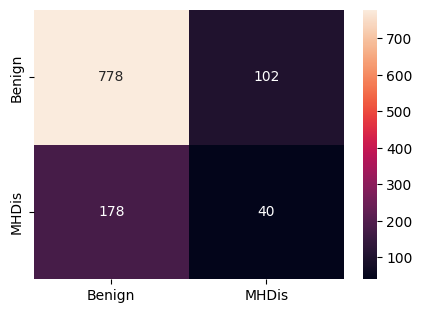

In [17]:
folder("results/val/")

for file in file_list_session:
    print(file)
    feature=feature_list[file]
    train=file_list_session[file][0]
    test=file_list_session[file][1]
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/val/{file}_VAL_chosed_output_ML_.csv"
    target_names=["Benign",file]
    ML(train,test,output_csv,feature,file,0)   

# TEST

In [18]:
file_list={
'SYN': ['../csvs\\dos-synflooding-1-dec.pcap_Flow.csv', '../csvs\\dos-synflooding-6-dec.pcap_Flow.csv'],
'HTTP': ['../csvs\\mirai-httpflooding-4-dec.pcap_Flow.csv', '../csvs\\http-flood -maze.csv'],
'ACK': ['../csvs\\mirai-ackflooding-4-dec.pcap_Flow.csv', '../csvs\\mirai-ackflooding-2-dec.pcap_Flow.csv'],
'UDP': ['../csvs\\mirai-udpflooding-4-dec.pcap_Flow.csv', '../csvs\\mirai-udpflooding-2-dec.pcap_Flow.csv'],
'ARP': ['../csvs\\mitm-arpspoofing-6-dec.pcap_Flow.csv', '../csvs\\mitm-arpspoofing-5-dec.pcap_Flow.csv'],
'SP': ['../csvs\\scan-hostport-3-dec.pcap_Flow.csv', '../csvs\\Edge-Port Scanning attack.pcap_Flow.csv'],
'BF': ['../csvs\\mirai-hostbruteforce-5-dec.pcap_Flow.csv','../csvs\\mirai-hostbruteforce-3-dec.pcap_Flow.csv'],
'OS': ['../csvs\\scan-portos-3-dec.pcap_Flow.csv', '../csvs\\BoT-IoT_OSScan.csv'],
'SCHD': ['../csvs\\scan-hostport-3-dec.pcap_Flow.csv', '../csvs\\scan-hostport-5-dec.pcap_Flow.csv'],
'MHDis': ['../csvs\\mirai-hostbruteforce-3-dec.pcap_Flow.csv', '../csvs\\mirai-hostbruteforce-5-dec.pcap_Flow.csv']}

SYN
['Src Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow IAT Mean', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Max', 'Fwd Header Len', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'SYN Flag Cnt', 'Subflow Fwd Pkts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Active Std', 'Active Max', 'Active Min', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           1    1     0  LR    0.999    0.943   1      0.943  0.97   0.939  0.943   26.062     0.001
 1  SYN           1    1     1  LR    0.999    0.966   1      0.966  0.982  0.964  0.966   30.662     0.001
 2  

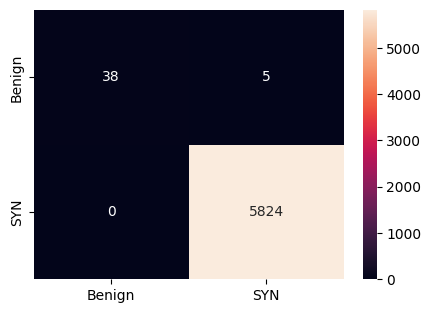





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           1    1     0  DT        1    0.989       1  0.989  0.994  0.988  0.989    0.078     0.001
 1  SYN           1    1     1  DT        1    0.989       1  0.989  0.994  0.988  0.989    0.061     0.001
 2  SYN           1    1     2  DT        1    0.989       1  0.989  0.994  0.988  0.989    0.073     0.002
 3  SYN           1    1     3  DT        1    0.989       1  0.989  0.994  0.988  0.989    0.081     0.002
 4  SYN           1    1     4  DT        1    0.989       1  0.989  0.994  0.988  0.989    0.058     0.001
 5  SYN           1    1     5  DT        1    0.989       1  0.989  0.994  0.988  0.989    0.083     0.001
 6  SYN           1    1     6  DT        1    0.989       1  0.989  0.994  0.988  0.989    0.066     0.001
 7  SYN           1    1

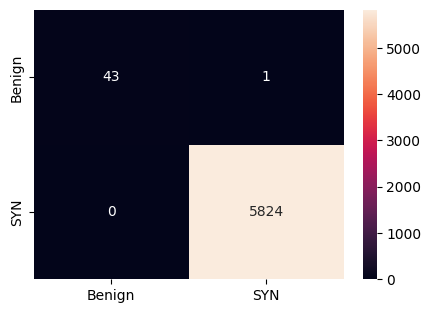





HTTP
['Dst Port', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Max', 'Fwd IAT Max', 'SYN Flag Cnt', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  HTTP          1    1     0  LR        1        1       1      1     1      1      1    0.435     0.001
 1  HTTP          1    1     1  LR        1        1       1      1     1      1      1    0.464     0.001
 2  HTTP          1    1     2  LR        1        1       1      1     1      1      1    0.749     0.001
 3  HTTP          1    1     3  LR        1        1       1      1     1      1      1    0.599     0
 4  HTTP          1    1     4  LR        1        1       1      1     1      1      1    0.529     0.001
 5  HTTP          1    1     5  LR        1        1       1      1     1      1      1    0.45      0
 6  HTTP          1    1     6  LR        

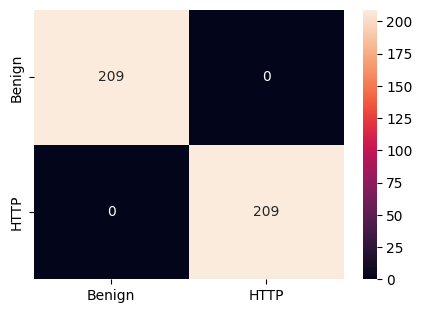





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  HTTP          1    1     0  DT        1        1       1      1     1      1      1    0.086     0
 1  HTTP          1    1     1  DT        1        1       1      1     1      1      1    0.005     0.001
 2  HTTP          1    1     2  DT        1        1       1      1     1      1      1    0.004     0
 3  HTTP          1    1     3  DT        1        1       1      1     1      1      1    0.013     0.001
 4  HTTP          1    1     4  DT        1        1       1      1     1      1      1    0.005     0.001
 5  HTTP          1    1     5  DT        1        1       1      1     1      1      1    0.004     0
 6  HTTP          1    1     6  DT        1        1       1      1     1      1      1    0.004     0
 7  HTTP          1    1     7  DT        1      

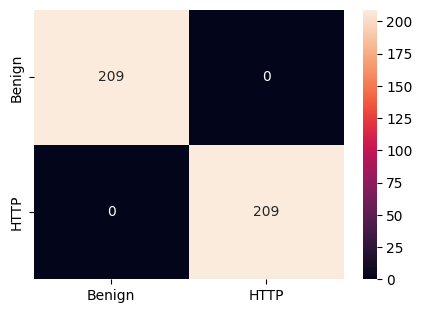





ACK
['Dst Port', 'Flow Duration', 'Tot Fwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Max', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Pkt Len Mean', 'Pkt Len Std', 'ACK Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Bwd Seg Size Avg', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Idle Mean', 'Idle Std', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           1    1     0  LR    0.979    0.982   0.975  0.982  0.978  0.957  0.982    2.878     0.001
 1  ACK           1    1     1  LR    0.981    0.984   0.978  0.984  0.981  0.961  0.984    0.648     0.001
 2  ACK 

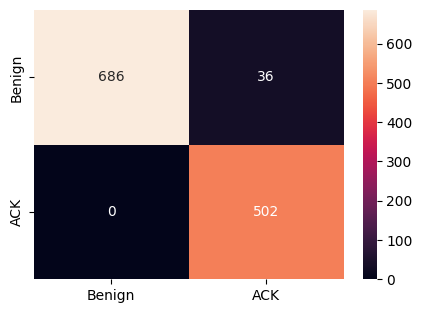





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  ACK           1    1     0  DT        1        1       1      1     1      1      1    0.008     0.001
 1  ACK           1    1     1  DT        1        1       1      1     1      1      1    0.008     0.001
 2  ACK           1    1     2  DT        1        1       1      1     1      1      1    0.009     0
 3  ACK           1    1     3  DT        1        1       1      1     1      1      1    0.006     0.001
 4  ACK           1    1     4  DT        1        1       1      1     1      1      1    0.007     0
 5  ACK           1    1     5  DT        1        1       1      1     1      1      1    0.01      0
 6  ACK           1    1     6  DT        1        1       1      1     1      1      1    0.011     0
 7  ACK           1    1     7  DT        1      

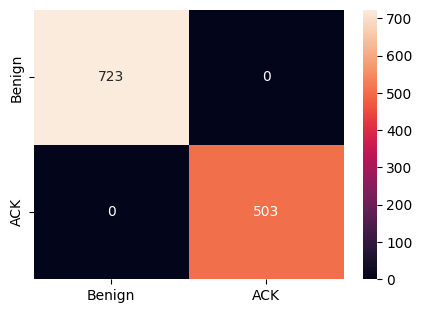





UDP
['Src Port', 'Flow Duration', 'TotLen Fwd Pkts', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow Byts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Fwd Act Data Pkts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  UDP           1    1     0  LR        1        1       1      1     1      1      1    0.017     0
 1  UDP           1    1     1  LR        1        1       1      1     1      1      1    0.004     0.001
 2  UDP           1    1     2  LR        1        1       1      1     1      1      1    0.005     0
 3  UDP           1    

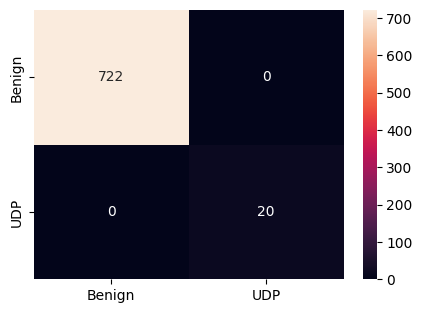





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           1    1     0  DT    1        1       1      1      1      1      1        0.004         0
 1  UDP           1    1     1  DT    1        1       1      1      1      1      1        0.003         0
 2  UDP           1    1     2  DT    1        1       1      1      1      1      1        0.002         0
 3  UDP           1    1     3  DT    1        1       1      1      1      1      1        0.003         0
 4  UDP           1    1     4  DT    1        1       1      1      1      1      1        0.003         0
 5  UDP           1    1     5  DT    1        1       1      1      1      1      1        0.002         0
 6  UDP           1    1     6  DT    1        1       1      1      1      1      1        0.002         0
 7  UDP           1    1

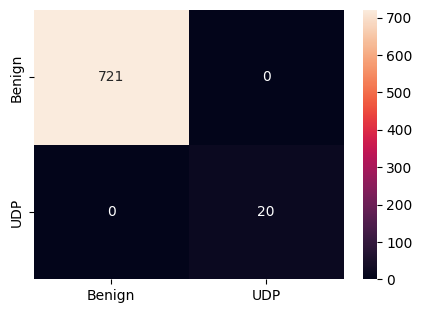





ARP
['Src Port', 'Dst Port', 'Protocol', 'Fwd Pkt Len Max', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow Pkts/s', 'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd Pkts/s', 'Pkt Len Var', 'SYN Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Active Std', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           1    1     0  LR    0.955    0.953   0.952  0.953  0.953  0.905  0.953    0.177     0
 1  ARP           1    1     1  LR    0.957    0.956   0.954  0.956  0.955  0.911  0.956    0.471     0
 2  ARP           1    1     2  LR    0.957    0.

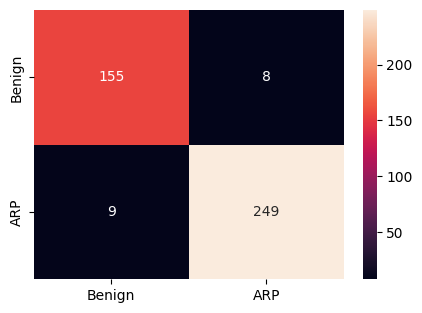





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           1    1     0  DT    0.974    0.977    0.97  0.977  0.973  0.946  0.977    0.012     0
 1  ARP           1    1     1  DT    0.974    0.977    0.97  0.977  0.973  0.946  0.977    0.006     0
 2  ARP           1    1     2  DT    0.974    0.977    0.97  0.977  0.973  0.946  0.977    0.011     0
 3  ARP           1    1     3  DT    0.974    0.977    0.97  0.977  0.973  0.946  0.977    0.014     0.001
 4  ARP           1    1     4  DT    0.974    0.977    0.97  0.977  0.973  0.946  0.977    0.006     0
 5  ARP           1    1     5  DT    0.974    0.977    0.97  0.977  0.973  0.946  0.977    0.014     0.001
 6  ARP           1    1     6  DT    0.974    0.977    0.97  0.977  0.973  0.946  0.977    0.005     0
 7  ARP           1    1     7  DT    0.974 

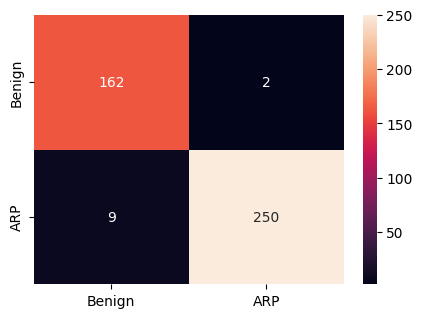





SP
['Protocol', 'Tot Fwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Flow Byts/s', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Header Len', 'Fwd Pkts/s', 'Pkt Len Min', 'Pkt Len Mean', 'Pkt Len Std', 'SYN Flag Cnt', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Active Std', 'Active Max', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  LR    0.992    0.856   0.996  0.856  0.914  0.827  0.856    0.002     0.002
 1  SP            1    1     1  LR    0.995    0.911   0.997  0.911  0.95   0.9

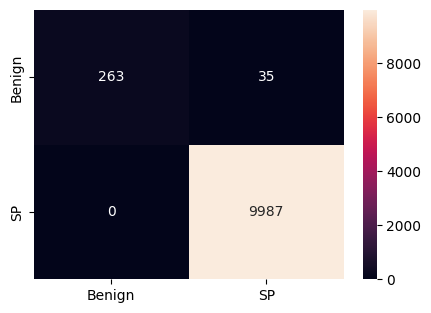





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SP            1    1     0  DT        1        1       1      1     1      1      1    0.002     0.002
 1  SP            1    1     1  DT        1        1       1      1     1      1      1    0.002     0.002
 2  SP            1    1     2  DT        1        1       1      1     1      1      1    0.006     0.001
 3  SP            1    1     3  DT        1        1       1      1     1      1      1    0.001     0.002
 4  SP            1    1     4  DT        1        1       1      1     1      1      1    0.002     0.001
 5  SP            1    1     5  DT        1        1       1      1     1      1      1    0.001     0.002
 6  SP            1    1     6  DT        1        1       1      1     1      1      1    0.003     0.006
 7  SP            1    1     7  D

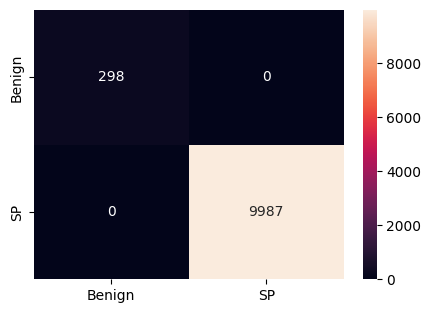





BF
['Dst Port', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Active Mean', 'Active Std', 'Active Max', 'Idle Mean', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  LR    0.883    0.704   0.794  0.704  0.736  0.475  0.704    1.886     0
 1  BF            1    1     1  LR    0.883    0.704   0.

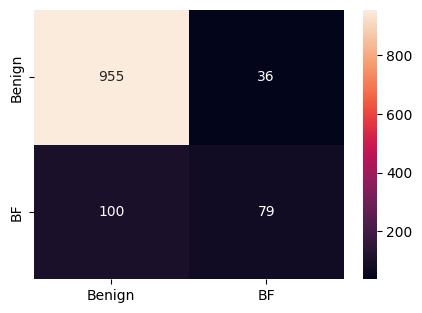





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  DT    0.971    0.917   0.97   0.917  0.941  0.882  0.917    0.025     0.001
 1  BF            1    1     1  DT    0.973    0.918   0.976  0.918  0.944  0.888  0.918    0.023     0.001
 2  BF            1    1     2  DT    0.968    0.906   0.967  0.906  0.933  0.867  0.906    0.035     0
 3  BF            1    1     3  DT    0.967    0.905   0.964  0.905  0.932  0.864  0.905    0.025     0
 4  BF            1    1     4  DT    0.969    0.916   0.964  0.916  0.938  0.876  0.916    0.021     0.003
 5  BF            1    1     5  DT    0.961    0.89    0.955  0.89   0.919  0.838  0.89     0.019     0.001
 6  BF            1    1     6  DT    0.962    0.895   0.953  0.895  0.921  0.843  0.895    0.021     0
 7  BF            1    1     7  DT  

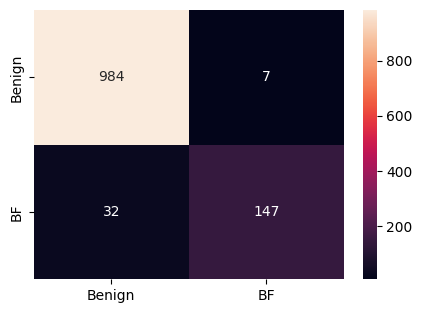





OS
['Dst Port', 'Protocol', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Bwd IAT Tot', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd Header Len', 'Pkt Len Min', 'Pkt Len Std', 'Pkt Len Var', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Fwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            1    1     0  LR    0.98     0.927   0.889  0.927  0.907  0.814  0.927    1.476     0.003
 1  OS            1    1  

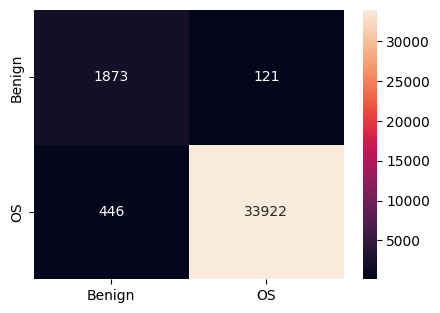





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            1    1     0  DT    0.981    0.986   0.873  0.986  0.921  0.842  0.986    0.009     0.007
 1  OS            1    1     1  DT    0.982    0.988   0.877  0.988  0.924  0.849  0.988    0.017     0.01
 2  OS            1    1     2  DT    0.982    0.986   0.877  0.986  0.924  0.848  0.986    0.015     0.009
 3  OS            1    1     3  DT    0.981    0.986   0.873  0.986  0.921  0.842  0.986    0.012     0.006
 4  OS            1    1     4  DT    0.982    0.986   0.877  0.986  0.924  0.848  0.986    0.017     0.016
 5  OS            1    1     5  DT    0.981    0.986   0.873  0.986  0.921  0.842  0.986    0.008     0.01
 6  OS            1    1     6  DT    0.981    0.986   0.873  0.986  0.921  0.842  0.986    0.013     0.007
 7  OS            1    1  

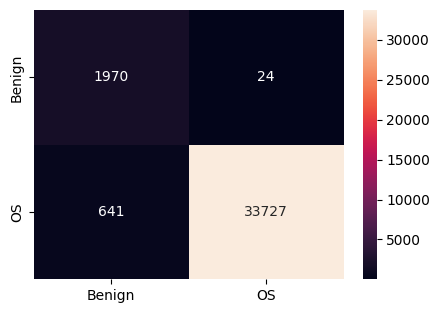





SCHD
['Dst Port', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow Pkts/s', 'Flow IAT Mean', 'Fwd IAT Tot', 'Fwd IAT Std', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd PSH Flags', 'Fwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Std', 'Idle Mean', 'Idle Std', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SCHD          1    1     0  LR        1        1       1      1     1      1      1    0.012     0.001
 1  SCHD          1    1     1  LR        1        1       1      1     1      1      1  

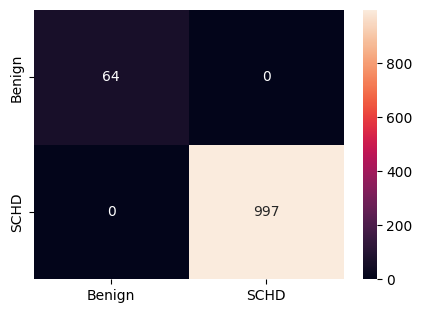





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          1    1     0  DT    1        1       1      1      1      1      1        0.003     0.001
 1  SCHD          1    1     1  DT    1        1       1      1      1      1      1        0.003     0
 2  SCHD          1    1     2  DT    0.996    0.969   0.998  0.969  0.983  0.966  0.969    0.013     0
 3  SCHD          1    1     3  DT    1        1       1      1      1      1      1        0.003     0
 4  SCHD          1    1     4  DT    1        1       1      1      1      1      1        0.002     0.001
 5  SCHD          1    1     5  DT    0.994    0.953   0.997  0.953  0.974  0.948  0.953    0.002     0.001
 6  SCHD          1    1     6  DT    1        1       1      1      1      1      1        0.002     0
 7  SCHD          1    1     7  DT    1 

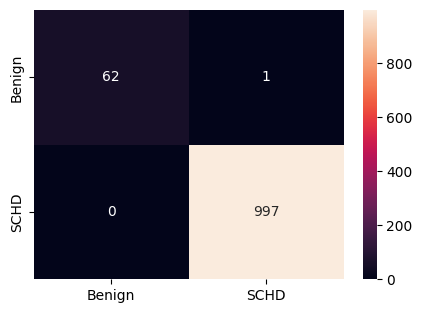





MHDis
['Src Port', 'Dst Port', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd Header Len', 'Fwd Pkts/s', 'Pkt Len Mean', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Active Mean', 'Active Std', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         1    1     0  LR    0.903    0.736   0.851  0.736  0.777  0.557  0.736    0.798     0
 1  MHDis         1    1     1  LR    0.903    0.736   0.851  0.736  0.777  0.557  0.736    0.793     0
 2  MHDis         1    1     2  LR    0

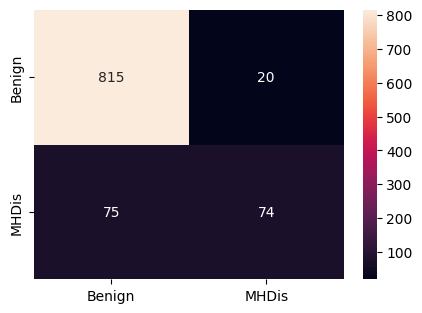





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         1    1     0  DT    0.987    0.962   0.986  0.962  0.974  0.947  0.962    0.02      0
 1  MHDis         1    1     1  DT    0.99     0.969   0.991  0.969  0.98   0.96   0.969    0.021     0.002
 2  MHDis         1    1     2  DT    0.989    0.966   0.991  0.966  0.978  0.955  0.966    0.023     0.001
 3  MHDis         1    1     3  DT    0.989    0.969   0.988  0.969  0.978  0.956  0.969    0.019     0
 4  MHDis         1    1     4  DT    0.987    0.965   0.983  0.965  0.974  0.948  0.965    0.025     0.001
 5  MHDis         1    1     5  DT    0.989    0.969   0.988  0.969  0.978  0.956  0.969    0.017     0
 6  MHDis         1    1     6  DT    0.988    0.965   0.987  0.965  0.976  0.951  0.965    0.018     0.001
 7  MHDis         1    1     7  DT  

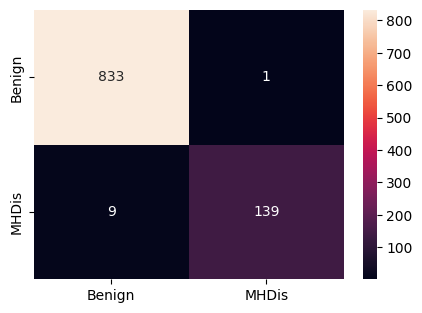

In [19]:
folder("results/test/")

for file in file_list:
    print(file)
    #if "UDP" in file:        feature=feature_list["UDP"]
    #else:        feature=feature_list[file]
    feature=feature_list[file]
    train=file_list[file][0]
    test=file_list[file][1]
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/test/{file}_TEST_chosed_output_ML_.csv"
    target_names=["Benign",file]
    ML(train,test,output_csv,feature,file,1)  

In [20]:
print(2)

2


In [21]:
files_add=find_the_way("./results/test/","_.csv")
files_add

results=[['Attack', 'ML','Acc', 'b_Acc', 'Prec', 'Rec',
       'F1', 'kap', 'ROC', 'tra-T', 'test-T']]
    
for i in tqdm(files_add):
    df=pd.read_csv(i)
    temp=df.values
    df = df.mean(numeric_only=True)
    df=list(df.values)
    temp=[temp[0][0],temp[0][4]]
    temp=temp+df[3:]
    results.append(temp)
results = pd.DataFrame (results[1:], columns = results[0])
results.to_csv("MEAN-resluts.csv",index=False)
print (tabulate(results, headers=list(results.columns)))

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 169.49it/s]

    Attack    ML         Acc     b_Acc      Prec       Rec        F1       kap       ROC        tra-T       test-T
--  --------  ----  --------  --------  --------  --------  --------  --------  --------  -----------  -----------
 0  ACK       DT    1         1         1         1         1         1         1          0.00909333  0.000300431
 1  ACK       LR    0.97031   0.974736  0.966336  0.974736  0.969631  0.939319  0.974736   0.900258    0.000613022
 2  ARP       DT    0.973995  0.976528  0.969716  0.976528  0.972819  0.945653  0.976528   0.00919993  0.000400591
 3  ARP       LR    0.956265  0.954669  0.953386  0.954669  0.954008  0.908018  0.954669   0.289299    0.000602818
 4  BF        DT    0.96587   0.905032  0.960847  0.905032  0.930173  0.860488  0.905032   0.0237905   0.000602436
 5  BF        LR    0.883191  0.703169  0.795029  0.703169  0.735708  0.474904  0.703169   1.85109     0.0006006
 6  HTTP      DT    1         1         1         1         1         1         1 

In [22]:
df=pd.read_csv("MEAN-resluts.csv")
bos=pd.DataFrame()
for i in df["Attack"].unique():
    small=df[df["Attack"]==i]
    bos[i]=small["F1"].values
    print(i)
bos.to_csv("tablo.csv",index=False)

ACK
ARP
BF
HTTP
MHDis
OS
SCHD
SP
SYN
UDP
